# CNN + SVM

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

from train_utils import plot_confusion_matrix, make_dataframe
import tensorflow as tf
from tensorflow import keras
from keras import metrics
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("Tensorflow version is ", tf.__version__)

Tensorflow version is  1.13.1


Using TensorFlow backend.


In [3]:
width_image = 224
height_image = 224
batch_size = 32
img_shape = (width_image, height_image, 3)

categories = os.listdir('dataset\\v3')

In [ ]:
# execute this if you want to train svm only from DenseNet121
model = tf.keras.applications.densenet.DenseNet121(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

In [4]:
# execute this if you want to train svm only from our fine-tuned net
from tensorflow.keras.models import Model

model = keras.models.load_model('.\\saved_model\\best_densenet121_ft_v3_2019_07_30.h5')
model.summary()

# remove the last softmax layer
model = Model(model.input, model.layers[-2].output)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 5,528,324
Non-trainable params: 1,513,280
_________________________________________________________________
_____________________

#### Extract feature from CNN

In [5]:
import os
 
import sklearn
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.externals import joblib
     
def extract_features(generator, model, size):
    features = np.empty((size, 1024))
    labels = []
    for i in range(0, size):
        img, label = generator.next()
        feature = model.predict(img)
        features[i,:] = np.squeeze(feature)
        labels.append(categories[np.argmax(label)])
        print("{0:.0f}%".format((i/size) * 100), end="\r")
    return features, np.array(labels)

In [8]:
# create a generator from all dataset, the svm split into training and test sets
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
#    horizontal_flip=True,
#    vertical_flip=True,
#    rotation_range=15.
)

train_svm_generator = train_datagen.flow_from_directory(
    directory='dataset\\v3',
    class_mode = 'categorical',
    target_size = (width_image, height_image),
    batch_size = 1)

Found 2435 images belonging to 4 classes.


In [9]:
features, labels = extract_features(train_svm_generator, model, size=len(train_svm_generator))

#### Start training SVM

In [10]:
#train_svm_classifer(features, labels, model_output_path):
"""
train_svm_classifer will train a SVM, saved the trained and SVM model and
report the classification performance

features: array of input features
labels: array of labels associated with the input features
model_output_path: path for storing the trained svm model
"""
# save 20% of data for performance evaluation
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

param = [
 #   {
 #       "kernel": ["linear"],
 #       "C": [1, 10, 100, 1000]
 #   },
    {
        "kernel": ["rbf"],
        "C": [10],#[1, 10, 100, 1000],
        "gamma": [1e-2, 1e-3]#, 1e-4, 1e-5]
    }
]

# request probability estimation
svm = SVC(probability=True)

# 10-fold cross validation, use 4 thread as each fold and each parameter set can be train in parallel
clf = GridSearchCV(svm, param,
        cv=10, n_jobs=5, verbose=3)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  18 out of  20 | elapsed:  2.1min remaining:   13.7s
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:  2.1min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=5,
             param_grid=[{'C': [10], 'gamma': [0.01, 0.001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)


Best parameters set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Confusion matrix:
Labels: glass,metal,paper,plastic

[[107   2   0   0]
 [  1  67   0   1]
 [  0   0 208   0]
 [  4   0   0  97]]

Classification report:
              precision    recall  f1-score   support

       glass       0.96      0.98      0.97       109
       metal       0.97      0.97      0.97        69
       paper       1.00      1.00      1.00       208
     plastic       0.99      0.96      0.97       101

    accuracy                           0.98       487
   macro avg       0.98      0.98      0.98       487
weighted avg       0.98      0.98      0.98       487

Accuratezza media della combinazione migliore: 0.988
Accuratezza sul training set: 1.000
Accuratezza sul validation set: 0.984


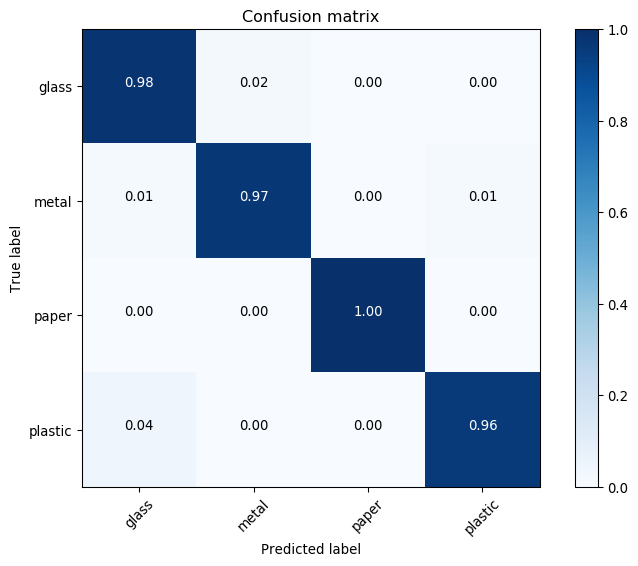

In [11]:
# print svm training info
print("\nBest parameters set:")
print(clf.best_params_)

y_predict=clf.best_estimator_.predict(X_test)

labels = sorted(list(set(labels)))
print("\nConfusion matrix:")
print("Labels: {0}\n".format(",".join(labels)))
print(confusion_matrix(y_test, y_predict, labels=labels))

print("\nClassification report:")
print(classification_report(y_test, y_predict))

# Calcolo accuratezza
print('Accuratezza media della combinazione migliore: %.3f' % clf.best_score_)
print('Accuratezza sul training set: %.3f' % clf.best_estimator_.score(X_train, y_train))
print('Accuratezza sul validation set: %.3f' % clf.best_estimator_.score(X_test, y_test))

plot_confusion_matrix(y_test, y_predict, labels)

In [14]:
model_output_path = '.\\saved_model\\best_densenet121_ft_v3_2019_07_30_svm.sav'
overwrite = True

if not os.path.exists(model_output_path) or overwrite:
    joblib.dump(clf.best_estimator_, model_output_path)
    print("Saved to {0}.".format(model_output_path))
else:
    print("Cannot save trained svm model to {0}.".format(model_output_path))

Saved to .\saved_model\best_densenet121_ft_v3_2019_07_30_svm.sav.


##### Try to predict with cnn-svm

In [15]:
loaded_svm = joblib.load(model_output_path)
print('Accuratezza sul validation set: %.3f' % loaded_svm.score(X_test, y_test))

Accuratezza sul validation set: 0.984


In [16]:
# previously loaded and modified for extract the features
loaded_cnn = model

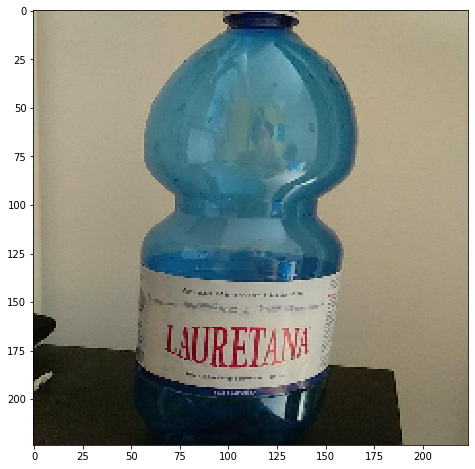

In [17]:
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input

img_path = 'plastic.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255
preprocess_input(x)
plt.imshow(img)

In [18]:
preds = loaded_cnn.predict(x)
loaded_svm.predict(preds)

array(['plastic'], dtype='<U7')